In [1]:
import copy
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from os import listdir
from os.path import isfile, join
import torch
from PIL import Image
from matplotlib.colors import ListedColormap
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as functional
from torchvision.models import vgg19
import torch.nn as nn
import random
import os

In [2]:
def seed_everything(seed):
    '''
    设置整个开发环境的seed
    :param seed:
    :param device:
    :return:
    '''
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # some cudnn methods can be random even after fixing the seed
    # unless you tell it to be deterministic
    torch.backends.cudnn.deterministic = True


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
train_path = '../data/archive/apples_segmentation/apples_segmentation/max_data/train/'
test_path = '../data/archive/apples_segmentation/apples_segmentation/max_data/test/'
backgrounds_path = '../data/archive/apples_segmentation/apples_segmentation/Sk_background/'
wild_test_path = '../data/archive/test_wild/test_wild/'

train_images = [join(train_path, f) for f in listdir(train_path) if
                isfile(join(train_path, f)) and f.split('.')[-1].lower() == 'jpg']
train_masks = [im.replace('.jpg', '.png').replace('obj', 'msk') for im in train_images]
test_images = [join(test_path, f) for f in listdir(test_path) if
               isfile(join(test_path, f)) and f.split('.')[-1].lower() == 'jpg']
test_masks = [im.replace('.jpg', '.png').replace('obj', 'msk') for im in test_images]
backgrounds_images = [join(backgrounds_path, f) for f in listdir(backgrounds_path) if
                      isfile(join(backgrounds_path, f)) and f.split('.')[-1].lower() == 'jpg']
wild_test_images = [join(wild_test_path, f) for f in listdir(wild_test_path) if
                    isfile(join(wild_test_path, f)) and f.split('.')[-1].lower() == 'jpg']

classes = ['background', 'health_apple', 'spoiled_apple']
colormaps = [[0, 0, 0], [0, 255, 0], [255, 0, 0]]

In [4]:
# 加载lab_mask
def load_lab_mask(mask_path):
    mask = plt.imread(mask_path)
    mask = (mask * 255).astype('uint8')
    mask_1 = np.where(mask == 2, 2, 0) + np.where(mask == 3, 2, 0) + np.where(mask == 1, 2, 0)
    mask_2 = np.where(mask == 4, 1, 0)
    mask = (mask_1 + mask_2).astype('uint8')
    return mask


# 加载wild_mask
def load_wild_mask(mask_path):
    mask = plt.imread(mask_path)
    mask = (mask * 255).astype('uint8')
    return mask[:, :, 0]


# 打印图片和语义分割结果
def show_img_with_mask(img_path):
    img = plt.imread(img_path)
    mask_path = img_path.replace('.jpg', '.png').replace('obj', 'msk')
    if 'apples_segmentation' in img_path:
        mask = load_lab_mask(mask_path)
    else:
        mask = load_wild_mask(mask_path)
    fig, axs = plt.subplots(1, 2, figsize=(12, 18))
    cmap = ListedColormap([[0, 0, 0], [.3, .8, .3], [1, 0, 0]])
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    axs[0].imshow(img)
    axs[1].imshow(mask, cmap=cmap)
    plt.show()


# 随机裁剪图像
def rand_crop(data, mask, high, width):
    number = random.randint(1,10)
    if number <= 4:
        im_width, im_high = data.size
        # 生成图像随机点
        left = np.random.randint(0, im_width - width)
        top = np.random.randint(0, im_high - high)
        right = left + width
        bottom = top + high
        data = data.crop((left, top, right, bottom))
        mask = mask.crop((left, top, right, bottom))
    else:
        data=data.resize((high,width),Image.BILINEAR)
        mask=mask.resize((high,width),Image.BILINEAR)
    return data, mask


# 单组图像转换
def img_transforms(data, mask, high, width):
    data, mask = rand_crop(data, mask, high, width)
    data_tfs = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.2]
        )
    ])
    data = data_tfs(data)
    mask = torch.from_numpy(np.array(mask))
    return data, mask


# 验证图像转换
def test_transforms(data, mask):
    data = data.resize((192, 192),Image.BILINEAR)
    mask = mask.resize((192, 192),Image.BILINEAR)
    data_tfs = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.2]
        )
    ])
    data = data_tfs(data)
    mask = torch.from_numpy(np.array(mask))
    return data, mask


# 预测到的标签转化为图像
def mask2image(mask, colormaps):
    h, w = mask.shape
    mask = mask.reshape(h * w, -1)
    image = np.zeros((h * w, 3), dtype='int32')
    for ii in range(len(colormaps)):
        index = np.where(mask == ii)
        image[index, :] = colormaps[ii]
    return image.reshape(h, w, 3)


# batch图像可视化
def inv_normalize_image(data):
    rgb_mean = np.array([0.485, 0.456, 0.406])
    rgb_std = np.array([0.229, 0.224, 0.225])
    data = data.astype('float32') * rgb_std + rgb_mean
    return data.clip(0, 1)

In [5]:
# 自定义数据集
class MyDataSet(data.Dataset):
    """
    读取图像，并进行裁剪
    """

    def __init__(self, data_list, mask_list, high, width, imtransform, colormap):
        self.high = high
        self.width = width
        self.imtransform = imtransform
        self.colormaps = colormap
        self.data_list = data_list
        self.mask_list = mask_list
        self.data_list = self._filter(data_list)
        self.mask_list = self._filter(mask_list)

    def _filter(self, imgs):
        return [im for im in imgs if (Image.open(im).size[1] > self.high and Image.open(im).size[0] > self.width)]

    def __getitem__(self, idx):
        img = self.data_list[idx]
        mask = self.mask_list[idx]
        img = Image.open(img)
        mask = Image.fromarray(load_lab_mask(mask))
        if 'train' in self.data_list[idx]:
            img, mask = self.imtransform(img, mask, self.high, self.width)
        else:
            img, mask = self.imtransform(img, mask)
        return img, mask

    def __len__(self):
        return len(self.data_list)

In [6]:
high, width = 192, 192
_train = MyDataSet(train_images, train_masks, high, width, img_transforms, colormaps)
_test = MyDataSet(test_images, test_masks, high, width, test_transforms, colormaps)
n_val = round(0.3 * len(_test))
_val, _train = data.random_split(_train, [n_val, len(_train) - n_val])
train_loader = data.DataLoader(_train, batch_size=4, shuffle=True, num_workers=0, pin_memory=True,drop_last=True)
test_loader = data.DataLoader(_test, batch_size=4, shuffle=True, num_workers=0,pin_memory=True,drop_last=True)
val_loader = data.DataLoader(_val, batch_size=4, shuffle=True, num_workers=0, pin_memory=True,drop_last=True)

In [7]:
print(len(val_loader))
print(len(train_loader))
for step, (b_x, b_y) in enumerate(train_loader):
    if step > 10:
        break
print("b_x:shape", b_x.shape)
print("b_y:shape", b_y.shape)

70
544


E:\Anaconda3\envs\my_envs\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
E:\Anaconda3\envs\my_envs\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.


b_x:shape torch.Size([4, 3, 192, 192])
b_y:shape torch.Size([4, 192, 192])


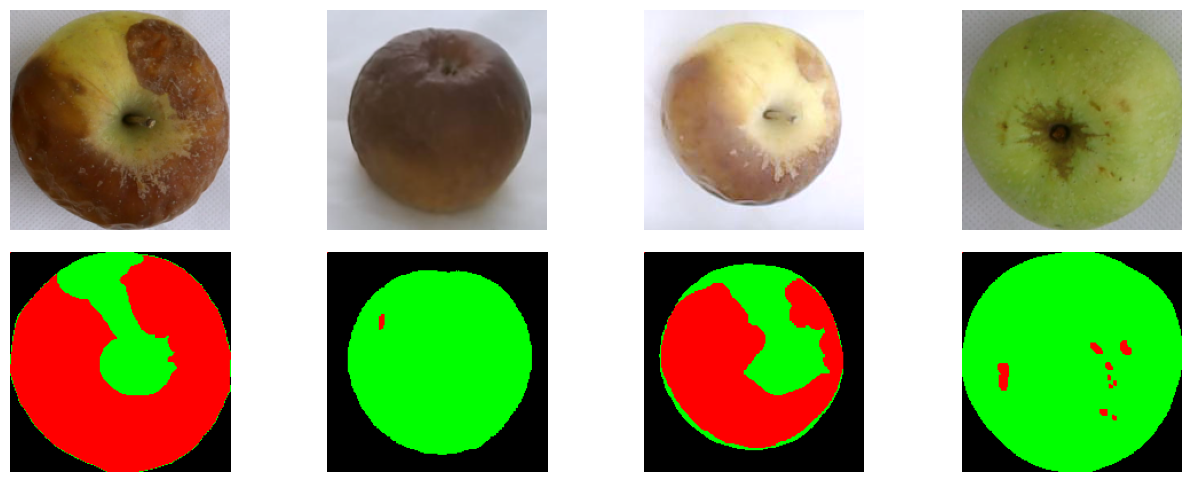

In [8]:
# 可视化一个batch
b_x_numpy = b_x.data.numpy()
b_x_numpy = b_x_numpy.transpose(0, 2, 3, 1)
b_y_numpy = b_y.data.numpy()
plt.figure(figsize=(16, 6))
for ii in range(4):
    plt.subplot(2, 4, ii + 1)
    plt.imshow(inv_normalize_image(b_x_numpy[ii]))
    plt.axis('off')
    plt.subplot(2, 4, ii + 5)
    plt.imshow(mask2image(b_y_numpy[ii], colormaps))
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [9]:
# model = vgg19(pretrained=False)
# model.to(device)
# base_model = model.features

In [10]:
# FCN语义分割网络
class FCN_8s(nn.Module):
    # class_num训练分类的类别
    def __init__(self, class_num):
        super().__init__()
        self.class_num = class_num
        self.base_model = vgg19(pretrained=False).features
        self.relu = nn.ReLU(inplace=True)
        # 转置卷积
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        # 归一化
        self.bn1 = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, 1, 1, 1)
        self.bn2 = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1, 1)
        self.bn4 = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1, 1)
        self.bn5 = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, class_num, kernel_size=1)
        self.maxpool_layers = {4: 'maxpool_1', 9: 'maxpool_2', 18: 'maxpool_3', 27: 'maxpool_4', 36: 'maxpool_5'}

    # 前向传播
    def forward(self, x):
        output = {}
        for name, layer in self.base_model._modules.items():
            x = layer(x)
            idx = int(name)
            if idx in self.maxpool_layers:
                output[self.maxpool_layers[idx]] = x
        x5 = output['maxpool_5']
        x4 = output['maxpool_4']
        x3 = output['maxpool_3']
        # 16
        score = self.relu(self.deconv1(x5))
        score = self.bn1(score + x4)
        # 8
        score = self.relu(self.deconv2(score))
        score = self.bn2(score + x3)
        # 4
        score = self.bn3(self.relu(self.deconv3(score)))
        # 2
        score = self.bn4(self.relu(self.deconv4(score)))
        # 1
        score = self.bn5(self.relu(self.deconv5(score)))
        score = self.classifier(score)
        return score

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        #input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512, bilinear)
        self.up2 = Up(512, 256, bilinear)
        self.up3 = Up(256, 128, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits



In [11]:
model_fcn = FCN_8s(3).to(device)

E:\Anaconda3\envs\my_envs\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
E:\Anaconda3\envs\my_envs\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
# 设标签宽W，长H
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)


def per_class_iu(hist):  # 分别为每个类别（在这里是19类）计算mIoU，hist的形状(n, n)
    return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))


def compute_mIoU(labels, pred_masks, num_classes):  # 计算mIoU的函数
    hist = np.zeros((num_classes, num_classes))  # hist初始化为全零，在这里的hist的形状是[19, 19]
    for ind in range(len(labels)):  # 读取每一个（图片-标签）对
        ## 2 pred
        pred = pred_masks[ind].cpu().numpy()  # 读取一张图像分割结果，转化成numpy数组
        ## 3 g_t
        label = labels[ind].cpu().numpy()  # 读取一张对应的标签，转化成numpy数组
        ## 4 计算
        hist += fast_hist(label.flatten(), pred.flatten(), num_classes)
    ## 5预测
    mIoUs = per_class_iu(hist)  # 计算所有验证集图片的逐类别mIoU值
    return round(np.nanmean(mIoUs) * 100, 2)


def train_model(model, criterion, optimizer, train_loader, val_loader, epoch_num):
    '''
    训练模型
    :param model:模型
    :param criterion:损失函数
    :param optimizer: 优化器
    :param train_loader: 训练数据将
    :param val_loader: 验证数据集
    :param epoch_num: 训练的轮数
    '''
    # 最优模型
    best_model_wts = copy.deepcopy(model.state_dict())
    # 最优损失率
    best_miou = 1e-10
    # 记录训练过程
    train_loss_all = []
    train_miou_all = []
    val_loss_all = []
    val_miou_all = []

    start_time = time.time()
    print('Start Train')
    print('-' * 20)
    for epoch in range(epoch_num):
        print('Epoch {}/{}'.format(epoch + 1, epoch_num))
        print('-' * 10)
        train_loss = 0.0
        train_num = 0
        val_loss = 0.0
        val_num = 0
        train_miou = 0.0
        val_miou = 0.0
        model.train()
        for step, (b_x, b_y) in enumerate(train_loader):
            optimizer.zero_grad()
            b_x = b_x.float().to(device)
            b_y = b_y.long().to(device)
            output = model(b_x)['out']
            output = functional.log_softmax(output, dim=1)
            pre_masks = torch.argmax(output, 1)
            loss = criterion(output, b_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(b_y)
            train_miou += compute_mIoU(b_y, pre_masks, 3) * len(b_y)
            train_num += len(b_y)
        # 计算一个epoch损失和精度
        train_loss_all.append(train_loss / train_num)
        train_miou_all.append(train_miou / train_num)
        print('epoch{} Train Loss:{:.4f}'.format(epoch + 1, train_loss_all[-1]))
        print('epoch{} Train miou:{:.4f}'.format(epoch + 1, train_miou_all[-1]))
        # 验证损失
        model.eval()
        for step, (b_x, b_y) in enumerate(val_loader):
            b_x = b_x.float().to(device)
            b_y = b_y.long().to(device)
            output = model(b_x)['out']
            output = functional.log_softmax(output, dim=1)
            pre_masks = torch.argmax(output, 1)
            loss = criterion(output, b_y)
            val_loss += loss.item() * len(b_y)
            val_miou += compute_mIoU(b_y, pre_masks, 3) * len(b_y)
            val_num += len(b_y)
        # 计算一个epoch的损失和精度
        val_loss_all.append(val_loss / val_num)
        val_miou_all.append(val_miou / val_num)
        print('epoch{} Val Loss:{:.4f}'.format(epoch + 1, val_loss_all[-1]))
        print('epoch{} Val miou:{:.4f}'.format(epoch + 1,val_miou_all[-1]))
        # 储存最好结果
        if val_miou_all[-1] > best_miou:
            best_miou = val_miou_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())

        # 每个epoch的花费时间
        cost_time = time.time() - start_time
        print('Complete in {:.0f}m {:.0f}s'.format(cost_time // 60, cost_time % 60))

    train_process = pd.DataFrame(
        data={'epoch': range(epoch_num), 'train_loss_all': train_loss_all, 'val_loss_all': val_loss_all,
              'train_miou_all': train_miou_all, 'val_miou_all': val_miou_all,
              'best_model_name': 'model_best_miou_{:.4f}.pkl'.format(best_miou)}
    )
    model.load_state_dict(best_model_wts)
    return model, train_process

E:\Anaconda3\envs\my_envs\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Start Train
--------------------
Epoch 1/1
----------


E:\Anaconda3\envs\my_envs\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
E:\Anaconda3\envs\my_envs\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.


epoch1 Train Loss:0.4017
epoch1 Train miou:70.8190
epoch1 Val Loss:0.2361
epoch1 Val miou:80.1011
Complete in 5m 15s


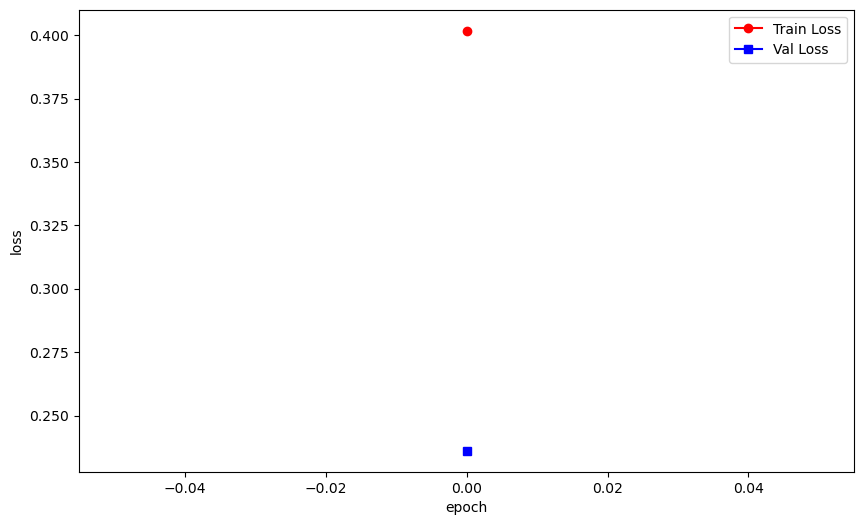

In [13]:
from torchvision.models.segmentation import deeplabv3_resnet101
import torch.nn as nn

model = deeplabv3_resnet101(pretrained=True)
model.aux_classifier[4] = nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
model.classifier[4] = nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
model.to(device)
# 学习率
LR = 0.0003
# 损失函数
loss_func = nn.NLLLoss()
# 优化器
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

# 训练模型
model, train_process = train_model(model, loss_func, optimizer, train_loader, val_loader, 1)

# 可视化训练过程
plt.figure(figsize=(10, 6))
plt.plot(train_process.epoch, train_process.train_loss_all, 'ro-', label="Train Loss")
plt.plot(train_process.epoch, train_process.val_loss_all, 'bs-', label="Val Loss")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [14]:
# 可视化训练过程
plt.figure(figsize=(10, 6))
plt.plot(train_process.epoch, train_process.train_acc_all, 'ro-', label="Train Acc")
plt.plot(train_process.epoch, train_process.val_acc_all, 'bs-', label="Val Acc")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'train_acc_all'

<Figure size 1000x600 with 0 Axes>

In [ ]:
torch.save(model_fcn, '../model/' + train_process.best_model_name[0])
# model_fcn=torch.load('model/fcn_8s_best_acc_0.9490.pkl')
# 可视化
model_fcn.eval()
val_miou=0.0
num=0
for step, (b_x, b_y) in enumerate(test_loader):
    b_x = b_x.float().to(device)
    b_y = b_y.long().to(device)
    output = model_fcn(b_x)
    output = functional.log_softmax(output, dim=1)
    pre_masks = torch.argmax(output, 1)
    val_miou += compute_mIoU(b_y, pre_masks, 3) * len(b_y)
    num+=len(b_y)

print('miou:'+str(val_miou/num))

E:\Anaconda3\envs\my_envs\lib\site-packages\ipykernel_launcher.py:71: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
E:\Anaconda3\envs\my_envs\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.


In [ ]:
# model_fcn=torch.load('model/fcn_8s_best_acc_0.9490.pkl')
# 可视化
model_fcn.eval()
for step, (b_x, b_y) in enumerate(test_loader):
    if step > 5:
        break
b_x = b_x.float().to(device)
b_y = b_y.long().to(device)
output = model_fcn(b_x)
output = functional.log_softmax(output, dim=1)
pre_masks = torch.argmax(output, 1)
b_x_numpy = b_x.cpu().data.numpy()
b_x_numpy = b_x_numpy.transpose(0, 2, 3, 1)
b_y_numpy = b_y.cpu().data.numpy()
pre_masks_numpy = pre_masks.cpu().numpy()
plt.figure(figsize=(16, 9))
for ii in range(4):
    plt.subplot(3, 4, ii + 1)
    plt.imshow(inv_normalize_image(b_x_numpy[ii]))
    plt.axis('off')
    plt.subplot(3, 4, ii + 5)
    plt.imshow(mask2image(b_y_numpy[ii], colormaps))
    plt.axis('off')
    plt.subplot(3, 4, ii + 9)
    plt.imshow(mask2image(pre_masks_numpy[ii], colormaps))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [ ]:
# # model_fcn = torch.load('model/fcn_8s_best_acc_0.9490.pkl')
# # 学习率
# LR = 0.0001
# # 损失函数
# loss_func = nn.NLLLoss()
# # 优化器
# optimizer = optim.Adam(model_fcn.parameters(), lr=LR, weight_decay=1e-4)

# # 训练模型
# model_fcn, train_process2 = train_model(model_fcn, loss_func, optimizer, train_loader, val_loader, 50)

# # 可视化训练过程
# plt.figure(figsize=(10, 6))
# plt.plot(train_process2.epoch, train_process2.train_loss_all, 'ro-', label="Train Loss")
# plt.plot(train_process2.epoch, train_process2.val_loss_all, 'bs-', label="Val Loss")
# plt.legend()
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()

In [ ]:
# # model_fcn = torch.load('model/fcn_8s_best_acc_0.9490.pkl')
# # 学习率
# LR = 0.0002
# # 损失函数
# loss_func = nn.NLLLoss()
# # 优化器
# optimizer = optim.Adam(model_fcn.parameters(), lr=LR, weight_decay=1e-4)

# # 训练模型
# model_fcn, train_process2 = train_model(model_fcn, loss_func, optimizer, train_loader, val_loader, 50)

# # 可视化训练过程
# plt.figure(figsize=(10, 6))
# plt.plot(train_process2.epoch, train_process2.train_loss_all, 'ro-', label="Train Loss")
# plt.plot(train_process2.epoch, train_process2.val_loss_all, 'bs-', label="Val Loss")
# plt.legend()
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.show()